In [1]:
import kagglehub
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import pickle
import os
from pathlib import Path
import timm

In [2]:
# Download dataset
path = kagglehub.dataset_download("paultimothymooney/kermany2018")
print("Path to dataset files:", path)

TRAIN_DATA_PATH = path + '/OCT2017 /train'
TEST_DATA_PATH = path + '/OCT2017 /test'
VAL_DATA_PATH = path + '/OCT2017 /val'

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using Colab cache for faster access to the 'kermany2018' dataset.
Path to dataset files: /kaggle/input/kermany2018
Using device: cuda


In [3]:

# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(TRAIN_DATA_PATH, transform=train_transform)
val_dataset = datasets.ImageFolder(VAL_DATA_PATH, transform=test_transform)
test_dataset = datasets.ImageFolder(TEST_DATA_PATH, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Class names
class_names = train_dataset.classes
print(f"Classes: {class_names}")


Classes: ['CNV', 'DME', 'DRUSEN', 'NORMAL']


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [4]:
# Model - MobileNetV3 Large equivalent using TIMM
model = timm.create_model('mobilenetv3_large_100', pretrained=True, num_classes=4)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.1M [00:00<?, ?B/s]

In [5]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=15):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss_avg = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss_avg)
        val_accs.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss_avg:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 50)

    history = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_acc': train_accs,
        'val_acc': val_accs
    }
    return history


In [6]:
# Train model
print("Starting training...")
history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=15)

# Save model and history
torch.save(model.state_dict(), 'eye_disease_model_pytorch.pth')
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history, f)

print("Model and history saved!")

Starting training...
Epoch 1/15:
Train Loss: 0.2754, Train Acc: 91.25%
Val Loss: 0.0362, Val Acc: 100.00%
--------------------------------------------------
Epoch 2/15:
Train Loss: 0.1486, Train Acc: 94.97%
Val Loss: 0.0220, Val Acc: 100.00%
--------------------------------------------------
Epoch 3/15:
Train Loss: 0.1194, Train Acc: 95.99%
Val Loss: 0.0201, Val Acc: 100.00%
--------------------------------------------------
Epoch 4/15:
Train Loss: 0.1017, Train Acc: 96.57%
Val Loss: 0.0107, Val Acc: 100.00%
--------------------------------------------------
Epoch 5/15:
Train Loss: 0.0891, Train Acc: 96.90%
Val Loss: 0.0573, Val Acc: 96.88%
--------------------------------------------------
Epoch 6/15:
Train Loss: 0.0788, Train Acc: 97.25%
Val Loss: 0.0105, Val Acc: 100.00%
--------------------------------------------------
Epoch 7/15:
Train Loss: 0.0706, Train Acc: 97.55%
Val Loss: 0.0131, Val Acc: 100.00%
--------------------------------------------------
Epoch 8/15:
Train Loss: 0.06

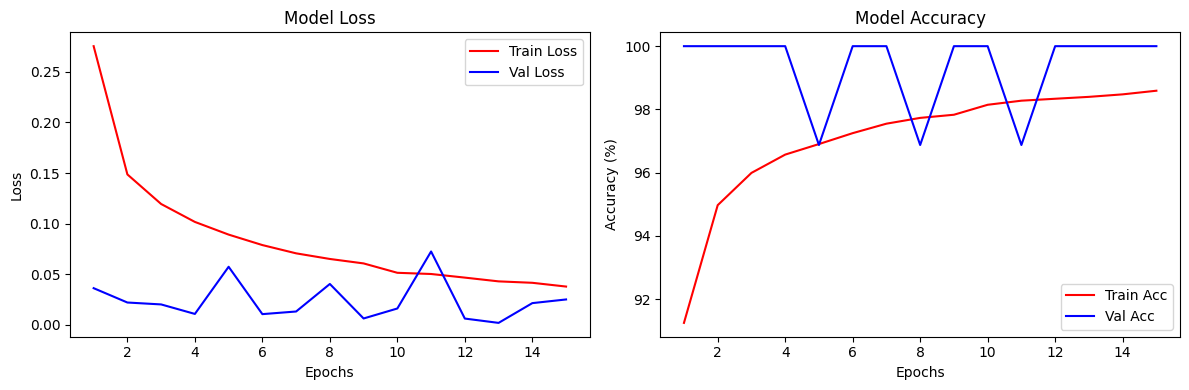

In [7]:
# Plot training history
epochs = range(1, 16)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_loss'], 'r-', label='Train Loss')
plt.plot(epochs, history['val_loss'], 'b-', label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_acc'], 'r-', label='Train Acc')
plt.plot(epochs, history['val_acc'], 'b-', label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.savefig('training_plots.png')
plt.show()


In [8]:
# Evaluation
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

y_true, y_pred = evaluate_model(model, test_loader)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

         CNV       0.99      1.00      0.99       242
         DME       1.00      1.00      1.00       242
      DRUSEN       1.00      0.99      0.99       242
      NORMAL       1.00      1.00      1.00       242

    accuracy                           1.00       968
   macro avg       1.00      1.00      1.00       968
weighted avg       1.00      1.00      1.00       968



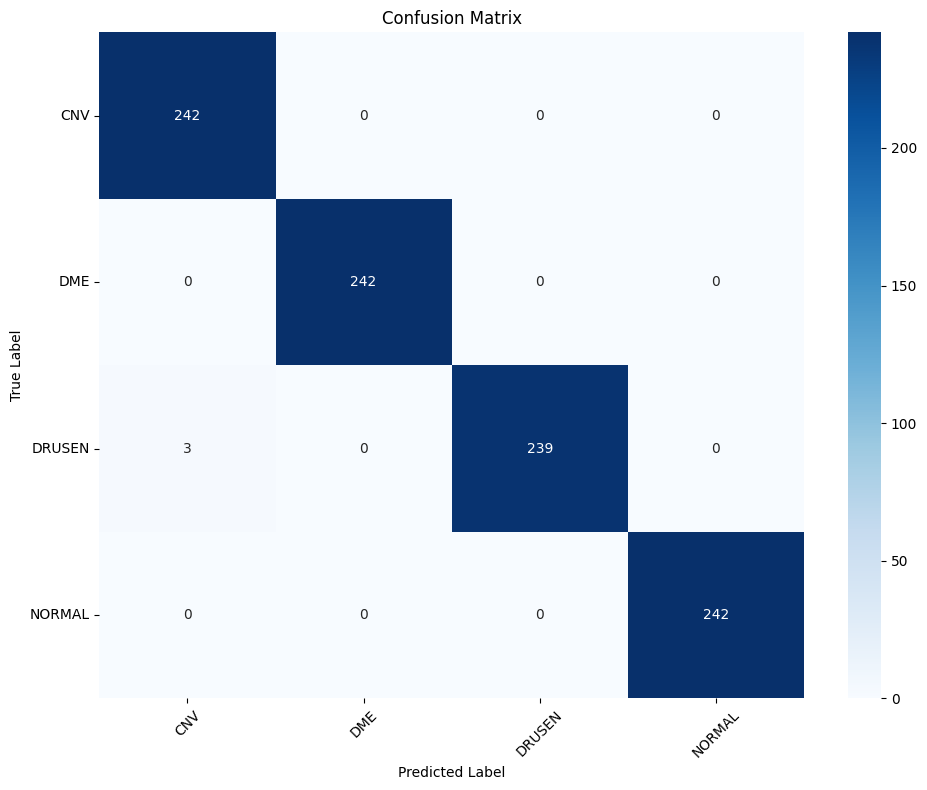

Evaluation complete!


In [9]:

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix_pytorch.png')
plt.show()

print("Evaluation complete!")
